In [29]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
sys.path.append(os.getcwd() + '/../../')
from matplotlib.patches import Ellipse
from numpy.random import multivariate_normal as m_normal
import plda
from scipy.stats import norm, chi2

# Define a bunch of helper plotting functions.
def cov_ellipse(cov, q=None, nsig=None, **kwargs):
    """ Code is slightly modified, but essentially borrowed from: 
         https://stackoverflow.com/questions/18764814/make-contour-of-scatter
    """
    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * norm.cdf(nsig) - 1
    else:
        raise ValueError('Either `q` or `nsig` should be specified')

    r2 = chi2.ppf(q, 2)
    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return width, height, rotation

def plot_scatter(ax, x, y, s=5, c='black', label='', plot_training_cov=False,
                 model=None):
    assert len(x.shape) == 1
    assert len(y.shape) == 1
    if plot_training_cov is True:
        assert model is not None

    ax.scatter(x, y, c=c, s=s, label=label)

    if plot_training_cov is True:
        cov = model.data[label]['cov']
        mean_x, mean_y = model.data[label]['mean']
        w, h, deg = cov_ellipse(cov, nsig=2)
        ell = Ellipse(xy=(mean_x, mean_y),
                      width=w, height=h,
                      angle=deg, linewidth=2)
        ell.set_facecolor('none')
        ell.set_edgecolor('black')
        ax.add_patch(ell)
    ax.set_aspect('equal')

    return ax

def lbls_to_clrs(lbls, lbl_clr_pairs):
    assert len(np.unique(lbls)) == len(lbl_clr_pairs)
    assert isinstance(lbls, np.ndarray)
    assert isinstance(lbl_clr_pairs, list)
    assert isinstance(lbl_clr_pairs[0], tuple)

    colors = np.empty((*lbls.shape, lbl_clr_pairs[0][1].shape[0]),
                      dtype=lbl_clr_pairs[0][1].dtype)
    for lbl, clr in lbl_clr_pairs:
        colors[lbls == lbl] = clr

    return colors

# Generate an artificial training and test dataset.

In [30]:
def gen_training_set(n_gaussians, sample_size, n_dims):
    cov = np.random.randint(-10, 10, (n_dims, n_dims))
    cov = np.matmul(cov, cov.T) + np.eye(n_dims) * np.random.rand(n_dims)

    pts = np.vstack([m_normal(np.ones(n_dims) * np.random.randint(-100, 100, 1),
                              cov, sample_size) \
                     for x in range(n_gaussians)])
    lbls = np.hstack([['gaussian_{}'.format(x)] * sample_size for x in range(n_gaussians)])

    return pts, lbls

n_gaussians = 5
sample_size = 100
n_dims = 2
n_test = 5000

# Initialize training and test data.
np.random.seed(0)
train_X, train_Y = gen_training_set(n_gaussians, sample_size, n_dims)

margin = np.sqrt(np.cov(train_X.T).diagonal().sum()) * .1
(min_x, min_y), (max_x, max_y) = np.min(train_X, axis=0) - margin,\
                                 np.max(train_X, axis=0) + margin
test = np.asarray([np.random.uniform(min_x, max_x, n_test),
                   np.random.uniform(min_y, max_y, n_test)]).T

# Create the model and make predictions.

In [31]:
# Use plda to classify test data.
classifier = plda.Classifier(train_X, train_Y)
classifier.fit_model()
predictions, log_probs = classifier.predict(test, standardize_data=True)

# Visualize predictions.

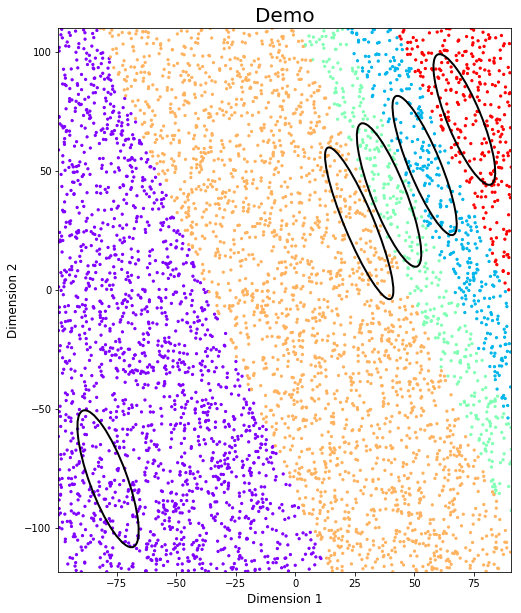

In [32]:
# Plot classified data.
colors = cm.rainbow(np.linspace(0, 1, n_gaussians))
unique = np.unique(predictions)
c = lbls_to_clrs(predictions, [pair for pair in zip(unique, colors)])
model = classifier.model

fig, ax_arr = plt.subplots(1)
for label in unique:
    idxs = predictions == label
    plot_scatter(ax_arr, test[idxs, 0], test[idxs, 1],
                 label=label, c=c[idxs, :], plot_training_cov=True,
                 model=model)

(min_x, min_y), (max_x, max_y) = np.min(test, axis=0), np.max(test, axis=0)
ax_arr.set_xlim(min_x, max_x)
ax_arr.set_ylim(min_y, max_y)
fig.set_size_inches(10, 10)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.title('Demo', fontsize=20)

plt.show()

In [33]:
# Unique categories.
model.data.keys()

dict_keys(['gaussian_4', 'gaussian_0', 'gaussian_1', 'gaussian_3', 'gaussian_2'])

In [34]:
model.data['gaussian_0'].keys()

dict_keys(['X', 'mean', 'n', 'fnames', 'cov'])

In [35]:
for x, y in zip(train_X[::50], train_Y[::50]):
    print(y, x)

gaussian_0 [-74.15164856 -98.41427575]
gaussian_0 [-71.5507819  -90.03471865]
gaussian_1 [55.10250168 49.24510997]
gaussian_1 [64.69385948 39.81474395]
gaussian_2 [30.76751905 54.46513794]
gaussian_2 [37.80116012 37.56215927]
gaussian_3 [30.60862144 25.845177  ]
gaussian_3 [31.14306017 16.30466116]
gaussian_4 [72.63803261 59.57616635]
gaussian_4 [83.16261763 55.76584255]


In [36]:
for x, y in zip(test[::500], predictions[::500]):
    print(y, x)

gaussian_4 [68.75774632 86.97997687]
gaussian_2 [  6.9247109  102.82273503]
gaussian_1 [73.77207899 26.31019444]
gaussian_0 [-29.50344444 -99.68188444]
gaussian_3 [-38.43325157   8.04683982]
gaussian_0 [-90.42348804  53.62491286]
gaussian_3 [-39.61493921  53.64834459]
gaussian_2 [ 62.88891438 -26.90913668]
gaussian_0 [-66.92579428 -95.44303968]
gaussian_3 [  2.94054124 -40.80783134]


# Accessing Model Parameters

In [37]:
classifier.model.Ψ  # Prior covariance in latent space.

array([[  0.        ,   0.        ],
       [  0.        , 587.44079228]])

In [38]:
classifier.model.A  # Used to transform the data to latent spae.

array([[-4.95494747,  2.17529251],
       [11.67545531,  2.18243953]])

In [39]:
classifier.model.m  # Mean of the training dataset.

array([22.63658095, 22.34330327])

In [47]:
# Category means in data space (i.e. not latent space).
means, labels = classifier.model.get_means(return_labels=True)
for label, mean in zip(labels, means):
    print(label, mean)

gaussian_4 [71.05544599 71.45130751]
gaussian_0 [-78.5915944  -79.44826685]
gaussian_1 [54.37257535 52.13593703]
gaussian_3 [26.90439342 27.84556694]
gaussian_2 [39.44208438 39.73197171]


In [48]:
# Category means in latent space. Paper denotes them as 'v'.
latent_means = classifier.model.whiten(np.asarray(means))

print(latent_means)

[[ 3.18416023e-02  2.23310834e+01]
 [-1.38649525e-02 -4.65670133e+01]
 [-1.23005323e-01  1.43091144e+01]
 [ 7.33136546e-02  2.12894484e+00]
 [ 3.17150184e-02  7.79787066e+00]]


In [49]:
latent_data = classifier.model.whiten(test)